# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Exploring Architectures](#GAN-vs-VAE)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

Seed function for reproducibility.

In [10]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Getting Started
The iris dataset will be used to validate the tabular data generation protocol, which despite its apparent simplicity may harbor pitfalls.

In [4]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Let's deep dive into our real data.

In [5]:
utils.describe_data(real_iris, 'target')

REAL                     
                       setosa versicolor virginica
MEAN sepal length (cm)  5.006      5.936     6.588
     sepal width (cm)   3.428      2.770     2.974
     petal length (cm)  1.462      4.260     5.552
     petal width (cm)   0.246      1.326     2.026
STD  sepal length (cm)  0.352      0.516     0.636
     sepal width (cm)   0.379      0.314     0.322
     petal length (cm)  0.174      0.470     0.552
     petal width (cm)   0.105      0.198     0.275
MIN  sepal length (cm)  4.300      4.900     4.900
     sepal width (cm)   2.300      2.000     2.200
     petal length (cm)  1.000      3.000     4.500
     petal width (cm)   0.100      1.000     1.400
MAX  sepal length (cm)  5.800      7.000     7.900
     sepal width (cm)   4.400      3.400     3.800
     petal length (cm)  1.900      5.100     6.900
     petal width (cm)   0.600      1.800     2.500
SKEW sepal length (cm)  0.116      0.102     0.114
     sepal width (cm)   0.040     -0.352     0.355
     petal length (cm)  0.103     -0.588     0.533
     petal width (cm)   1.216     -0.030    -0.126
KURT sepal length (cm) -0.346     -0.599    -0.088
     sepal width (cm)   0.744     -0.448     0.520
     petal length (cm)  0.805     -0.074    -0.256
     petal width (cm)   1.434     -0.488    -0.661
IQR  sepal length (cm)  0.400      0.700     0.675
     sepal width (cm)   0.475      0.475     0.375
     petal length (cm)  0.175      0.600     0.775
     petal width (cm)   0.100      0.300     0.500

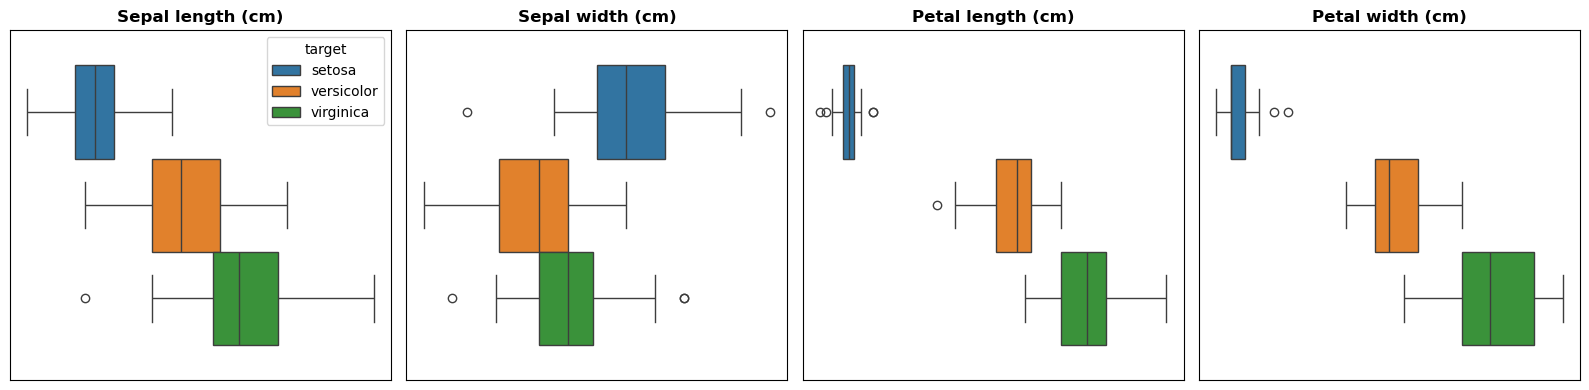

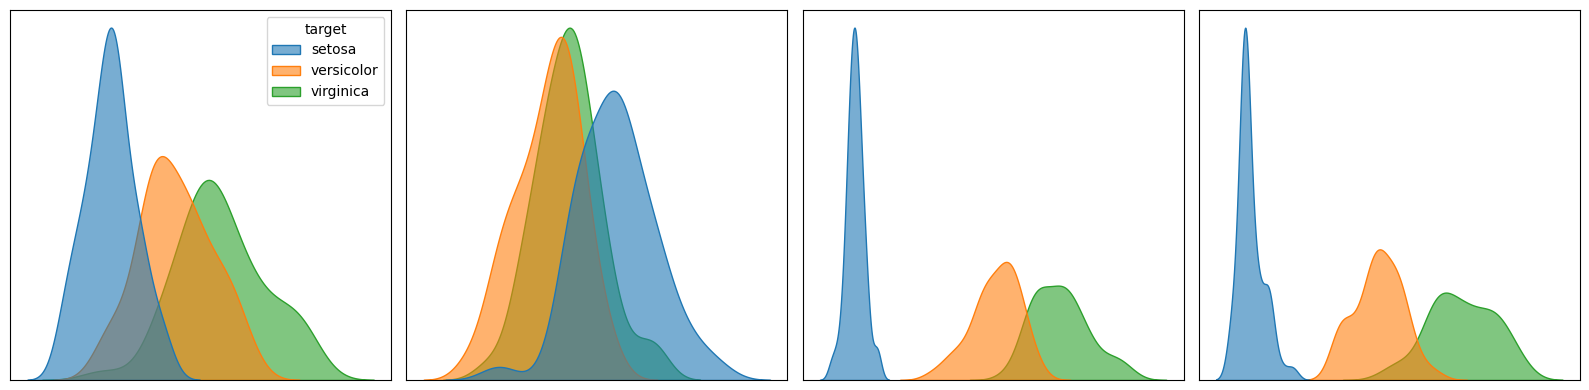

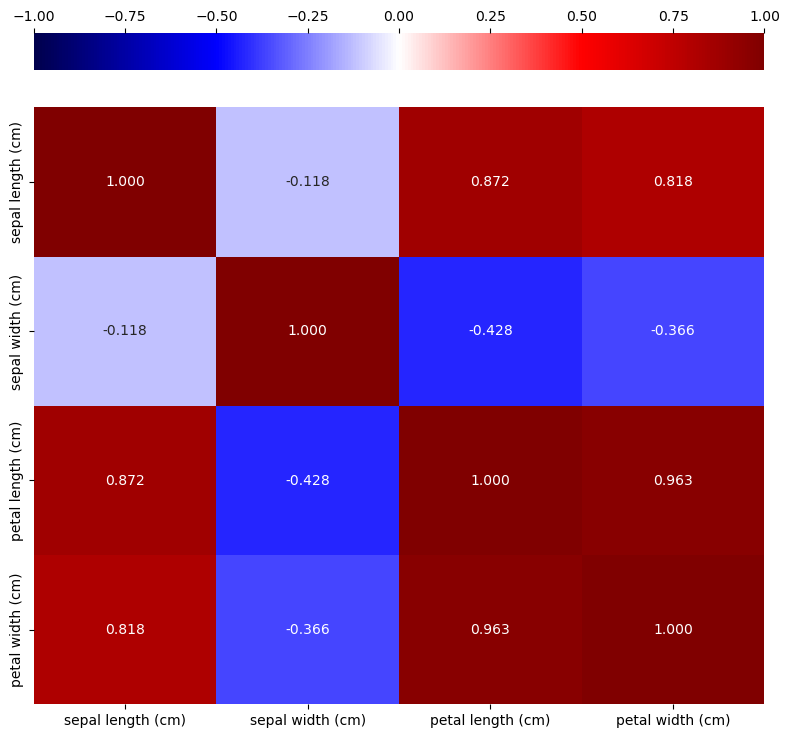

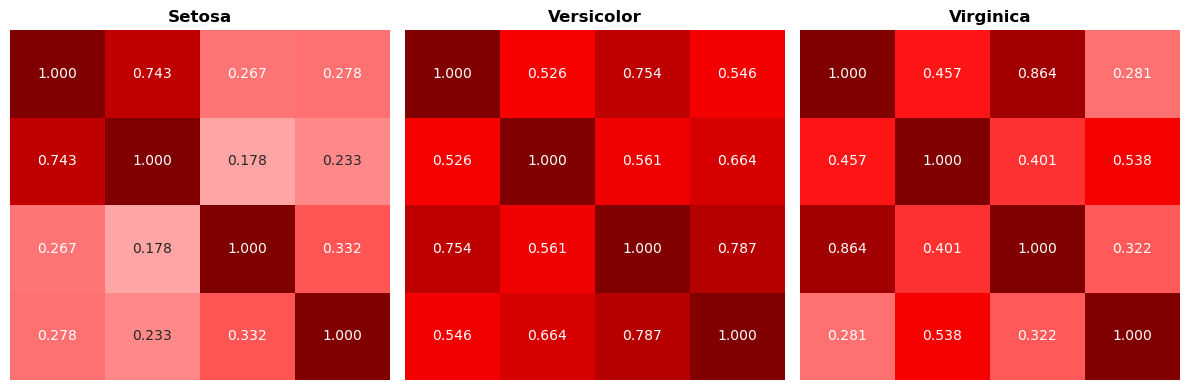

In [6]:
utils.plot_data(real_iris, 'target')

Throughout the notebook we will make comparisons between two datasets, one real and one synthetic; the following dataset, generated by adding normal noise to the real one, is used to introduce the comparison functions.

In [7]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.190991,1.653788,0.794514,0.988887,setosa
1,2.447346,2.638445,1.840717,-0.758691,setosa
2,3.235198,2.069282,2.594958,0.508633,setosa
3,6.285995,2.412523,1.911992,0.323892,setosa
4,3.780920,3.802776,3.704215,-0.587558,setosa


Let's start with comparisons! 

First of all a simply comparison between descriptives.

In [8]:
utils.describe_data(real_iris, 'target', df)

REAL                      SYNTHETIC             \
                       setosa versicolor virginica    setosa versicolor   
MEAN sepal length (cm)  5.006      5.936     6.588     4.957      6.062   
     sepal width (cm)   3.428      2.770     2.974     3.580      2.672   
     petal length (cm)  1.462      4.260     5.552     1.496      4.272   
     petal width (cm)   0.246      1.326     2.026     0.339      1.374   
STD  sepal length (cm)  0.352      0.516     0.636     1.283      1.164   
     sepal width (cm)   0.379      0.314     0.322     1.213      0.896   
     petal length (cm)  0.174      0.470     0.552     0.971      0.893   
     petal width (cm)   0.105      0.198     0.275     0.988      1.096   
MIN  sepal length (cm)  4.300      4.900     4.900     2.447      3.321   
     sepal width (cm)   2.300      2.000     2.200     0.820      0.526   
     petal length (cm)  1.000      3.000     4.500    -0.462      2.201   
     petal width (cm)   0.100      1.000     1.400    -1.425     -1.554   
MAX  sepal length (cm)  5.800      7.000     7.900     7.776      8.272   
     sepal width (cm)   4.400      3.400     3.800     6.996      4.670   
     petal length (cm)  1.900      5.100     6.900     3.704      7.119   
     petal width (cm)   0.600      1.800     2.500     2.466      3.651   
SKEW sepal length (cm)  0.116      0.102     0.114     0.225     -0.010   
     sepal width (cm)   0.040     -0.352     0.355     0.112     -0.148   
     petal length (cm)  0.103     -0.588     0.533    -0.071      0.370   
     petal width (cm)   1.216     -0.030    -0.126     0.077     -0.331   
KURT sepal length (cm) -0.346     -0.599    -0.088    -0.835     -0.567   
     sepal width (cm)   0.744     -0.448     0.520     0.341     -0.091   
     petal length (cm)  0.805     -0.074    -0.256    -0.699      0.872   
     petal width (cm)   1.434     -0.488    -0.661    -0.848      0.057   
IQR  sepal length (cm)  0.400      0.700     0.675     1.949      1.783   
     sepal width (cm)   0.475      0.475     0.375     1.311      1.120   
     petal length (cm)  0.175      0.600     0.775     1.315      0.985   
     petal width (cm)   0.100      0.300     0.500     1.513      1.276   

                                  
                       virginica  
MEAN sepal length (cm)     6.367  
     sepal width (cm)      3.141  
     petal length (cm)     5.365  
     petal width (cm)      1.821  
STD  sepal length (cm)     1.056  
     sepal width (cm)      1.136  
     petal length (cm)     1.114  
     petal width (cm)      1.105  
MIN  sepal length (cm)     3.884  
     sepal width (cm)      0.962  
     petal length (cm)     2.782  
     petal width (cm)     -0.394  
MAX  sepal length (cm)     8.825  
     sepal width (cm)      5.502  
     petal length (cm)     7.382  
     petal width (cm)      4.202  
SKEW sepal length (cm)     0.145  
     sepal width (cm)      0.005  
     petal length (cm)    -0.128  
     petal width (cm)     -0.042  
KURT sepal length (cm)     0.130  
     sepal width (cm)     -0.776  
     petal length (cm)    -0.603  
     petal width (cm)     -0.728  
IQR  sepal length (cm)     1.167  
     sepal width (cm)      1.626  
     petal length (cm)     1.488  
     petal width (cm)      1.582

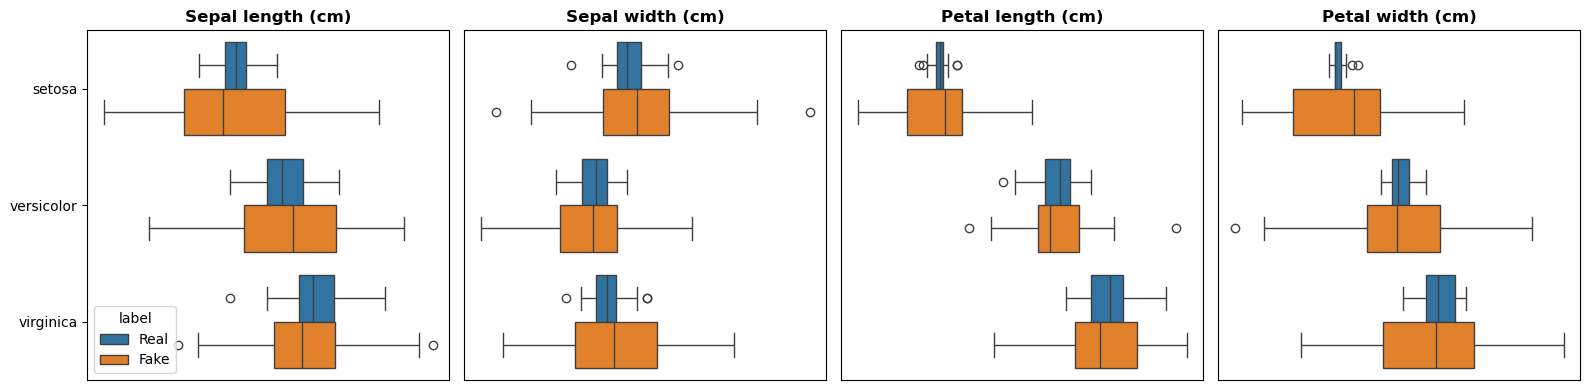

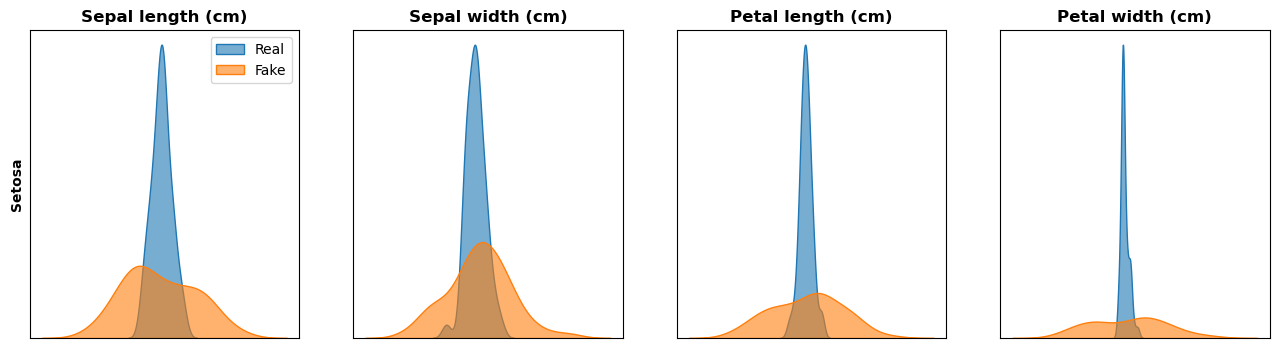

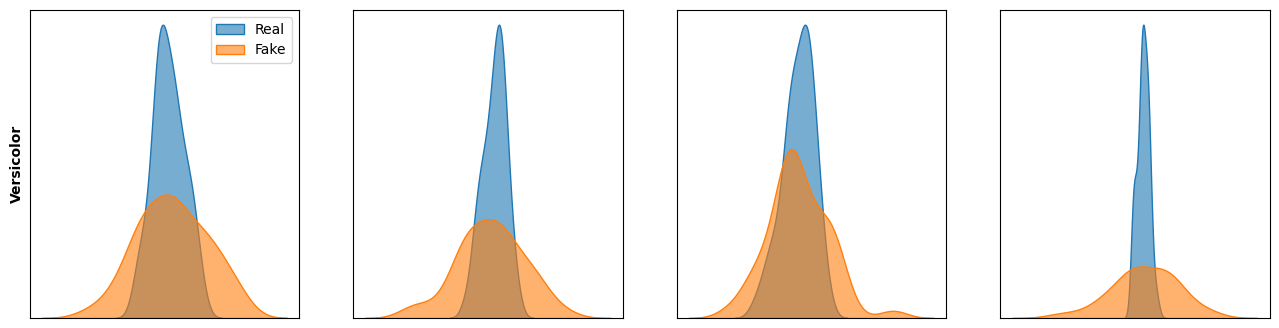

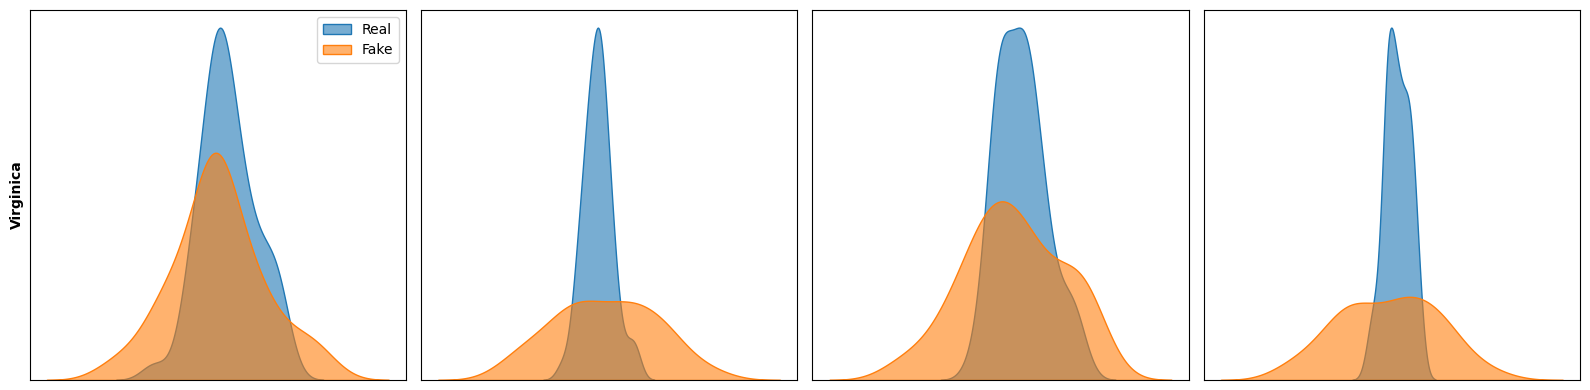

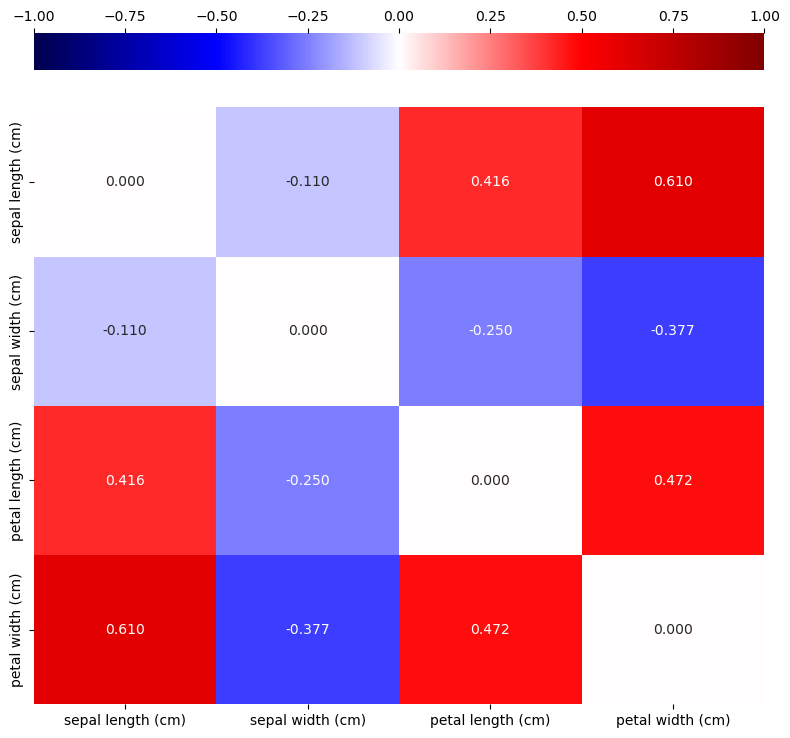

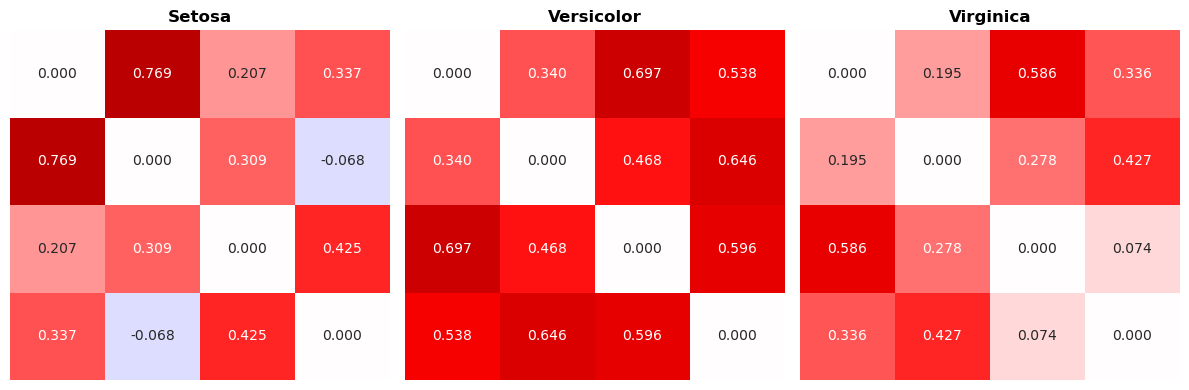

In [9]:
utils.plot_data(real_iris, 'target', df)

Throughout the work, the goal will be to minimize the differences, numerical and graphical, between the actual and synthetic data. Two different architectures will be used to achieve this goal: the Variational Auto Encoder **(VAE)** and the Generative Adversarial Network **(GAN)**, and the one that will show the best performance for the same task complexity and resources will be selected.

## GAN vs VAE

Both valid, the two approaches show different challenges and advantages:

1. **Variational Auto Encoder**:

Pros:
- Easy to train
- We can look inside the neaural network "Black Box"

Cons:

- Less coverage of variability
- Assumption of data normality

2. **Generative Adversarial Network**:

Pros:
- More realistic generated data
- Flexibility with respect to actual data distributions

Cons:
- Hard to train (model collapse, lot of resources, lot of data)
- Lower interpretability

